In [1]:
import re
from nltk import TreebankWordTokenizer
from transformers import DistilBertModel, DistilBertConfig, DistilBertTokenizer, TFDistilBertForSequenceClassification
from transformers import DefaultFlowCallback, PrinterCallback 
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras import backend as K
import numpy as np
import os
import random
import time

import logging
logging.basicConfig(level=logging.ERROR)
from transformers import TFBertPreTrainedModel,TFDistilBertMainLayer
from transformers.modeling_tf_utils import (
    TFQuestionAnsweringLoss,
    TFTokenClassificationLoss,
    get_initializer,
    keras_serializable,
    shape_list,
)
import pandas as pd
from sklearn.metrics import roc_auc_score


from tensorflow import keras

print('loading training and val data')
print('loading data', flush=True)
time.sleep(.2)

def convert_example_to_feature(review):
  
  # combine step for tokenization, WordPiece vector mapping, adding special tokens as well as truncating reviews longer than the max length
    return tokenizer.encode_plus(review, 
                add_special_tokens = True, # add [CLS], [SEP]
                max_length = max_length, # max length of the text that can go to BERT
                pad_to_max_length = True, # add [PAD] tokens
                return_attention_mask = True, # add attention mask to not focus on pad tokens
                truncation=True,
                return_token_type_ids = True
              )
# map to the expected input to TFBertForSequenceClassification, see here 
def map_example_to_dict(input_ids, attention_masks, token_type_ids, label):
    return {
      "input_ids": input_ids,
      "token_type_ids": token_type_ids,
      "attention_mask": attention_masks,
  }, label

def encode_examples(ds, limit=-1):
    # prepare list, so that we can build up final TensorFlow dataset from slices.
    input_ids_list = []
    token_type_ids_list = []
    attention_mask_list = []
    label_list = []
    if (limit > 0):
        ds = ds.take(limit)
    
    for (i, row) in enumerate(ds.values):
#     for index, row in ds.iterrows():
#         review = row["text"]
#         label = row["y"]
        review = row[0]
        label = list(row[1:])
        bert_input = convert_example_to_feature(review)
  
        input_ids_list.append(bert_input['input_ids'])
        token_type_ids_list.append(bert_input['token_type_ids'])
        attention_mask_list.append(bert_input['attention_mask'])
        label_list.append(label)
    return tf.data.Dataset.from_tensor_slices((input_ids_list, attention_mask_list, token_type_ids_list, label_list)).map(map_example_to_dict)

   
class TFBertForMultilabelClassification(TFBertPreTrainedModel):

    def __init__(self, config, *inputs, **kwargs):
        super(TFBertForMultilabelClassification, self).__init__(config, *inputs, **kwargs)
        self.num_labels = config.num_labels

        self.bert =  TFDistilBertMainLayer(config, name="distilbert")
        self.dropout = tf.keras.layers.Dropout(config.hidden_dropout_prob)
        self.classifier = tf.keras.layers.Dense(config.num_labels,
                                                kernel_initializer=get_initializer(config.initializer_range),
                                                name='classifier',
                                                activation='sigmoid')

    def call(self, inputs, **kwargs):
        outputs = self.bert(inputs, **kwargs)
        
        pooled_output = outputs[0][:,0]

        pooled_output = self.dropout(pooled_output, training=kwargs.get('training', False))
        logits = self.classifier(pooled_output)

        outputs = (logits,) + outputs[2:]  # add hidden states and attention if they are here

        return outputs  # logits, (hidden_states), (attentions)



def measure_auc(label,pred):
  auc = [roc_auc_score(label[:,i],pred[:,i]) for i in list(range(6))]
  return pd.DataFrame({"label_name":["toxic","severe_toxic","obscene","threat","insult","identity_hate"],"auc":auc})

 # parameters

 
print('loading data', flush=True)
print('loading data')

val_data =  pd.read_csv('../data/oasis_val.csv',nrows=6)
test_data = pd.read_csv('../data/oasis_test.csv',nrows=6)
combined = pd.concat([val_data,test_data])


combined=combined[[combined.columns[2]]+list(combined.columns[3:])]

model_path = "distilbert-base-uncased" #模型路径，建议预先下载(https://huggingface.co/bert-base-uncased#)

# parameters
max_length = 512
batch_size = 8
learning_rate = 2e-5
number_of_epochs = 100
num_classes = len(combined.iloc[0])-1

# tokenizer
tokenizer = DistilBertTokenizer.from_pretrained(model_path)
# train dataset
# ds_train_encoded = encode_examples(train_data)
# val dataset
ds_val_encoded = encode_examples(combined)
# test dataset
# ds_test_encoded = encode_examples(test_data).batch(batch_size)

ds_val_encoded

model = TFBertForMultilabelClassification.from_pretrained("../predict_sapsii/checkpoints/distilbert_OASIS__5.h5")

y_true = [x[1] for x in list(ds_val_encoded)]

outs=model.predict(np.array([x[0]['input_ids'] for x in list(ds_val_encoded)]))

y_pred = np.round(outs[0])

outs[0]

combined#.columns[1:]

preds_df = pd.DataFrame(outs[0],columns=list(combined.columns[1:]))
true_df = pd.DataFrame([list(x.numpy())for x in y_true],columns=[x+'_true'for x in combined.columns[1:]])
results_df = pd.concat([preds_df,true_df],axis=1)

results_df['TEXT']=list(combined['TEXT'])

# results_df.to_csv('val_test_OASIS_preds.csv')

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import pandas as pd

In [2]:
results_df=pd.read_csv('val_test_OASIS_preds_disch.csv',index_col=0)

In [3]:
# results_df

In [4]:
results_df.columns[10]

'age_score_true'

In [6]:
fpr = dict()
tpr = dict()
roc_auc = dict()
concepts = results_df.columns[:10]

y_true = results_df[[x+'_true' for x in concepts]].to_numpy()
y_score = results_df[concepts].to_numpy()
for concept in concepts:
    fpr[concept], tpr[concept], _ = roc_curve(results_df[concept+'_true'], results_df[concept])
    roc_auc[concept] = auc(fpr[concept], tpr[concept])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

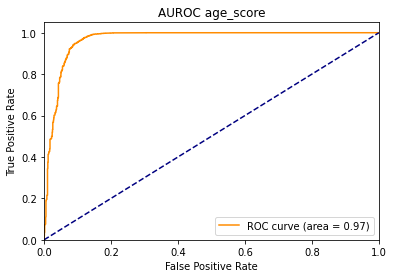

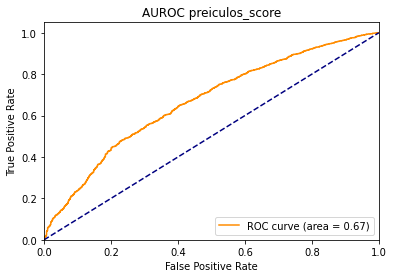

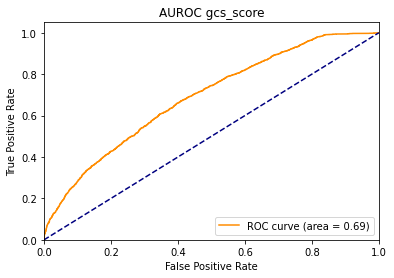

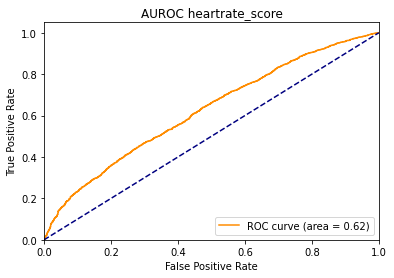

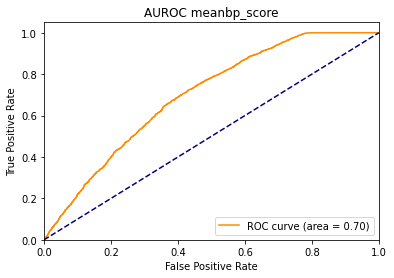

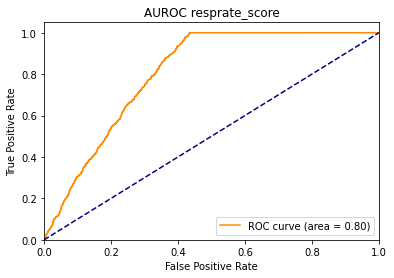

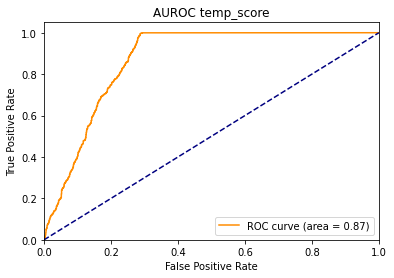

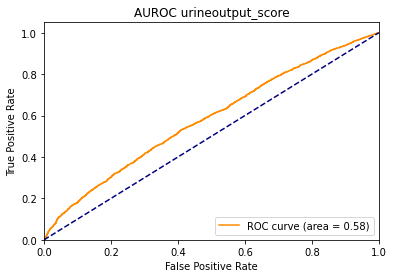

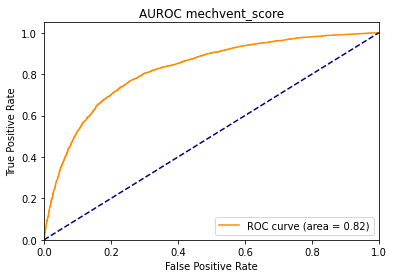

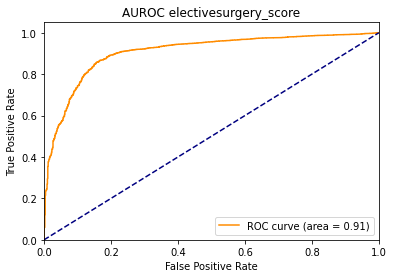

In [7]:
plt.figure()

for concept in concepts:
    plt.plot(fpr[concept], tpr[concept], color='darkorange',
              label='ROC curve (area = %0.2f)' % roc_auc[concept])
    plt.plot([0, 1], [0, 1], color='navy',  linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('AUROC ' +concept)
    plt.legend(loc="lower right")
    plt.show()

In [8]:
# roc_curve(results_df[results_df.columns[10]],results_df[results_df.columns[0]])
# filtered

In [9]:
## thresh=0.9999999
thresh=0.9
for concept in results_df.columns[:10]:
    filtered = results_df[results_df[concept+'_true'].apply(lambda x: x==1)][[concept, concept+'_true','TEXT']].sort_values(by=concept,ascending=False).iloc[:1000]
    filtered= filtered[filtered[concept]>thresh]

#     filtered = results_df[results_df.apply(lambda row: row[concept]>=thresh and row[concept+'_true']==1 , axis=1)]['TEXT']
    halfthresh = results_df[results_df.apply(lambda row: row[concept]>=0.5 and row[concept+'_true']==1 , axis=1)]['TEXT']

    print(concept,len(filtered),len(halfthresh), sum(results_df[concept+'_true']),filtered[concept].mean())
    print('--------\n\n')
    
    filtered.to_csv('../concept_listfiles/filtered_disch_'+concept)
#     try:
#         print(filtered['TEXT'].iloc[-1])
#     except:
#         pass

age_score 1000 7494 7607 0.99999695038
--------


preiculos_score 1000 6965 7737 0.99896937719
--------


gcs_score 568 1224 2556 0.9684351442429576
--------


heartrate_score 1000 5959 6607 0.99732919111
--------


meanbp_score 1000 3379 4697 0.9792349971400001
--------


resprate_score 1000 7104 7148 0.9981917874099999
--------


temp_score 1000 7456 7458 0.9996875487
--------


urineoutput_score 1000 4735 5954 0.9740189501
--------


mechvent_score 1000 3130 3896 0.99597250881
--------


electivesurgery_score 1000 7418 7780 0.99999482815
--------




In [6]:
for concept in results_df.columns[:10]:
    print(concept)
    for i in range(10):
        filtered = results_df[results_df[concept+'_true'].apply(lambda x: x==0)][[concept, concept+'_true','TEXT']].iloc[i*500:(i+1)*500]
        filtered.to_csv('../concept_listfiles/negative500_filtered_disch_'+concept+'_'+str(i))

age_score
preiculos_score
gcs_score
heartrate_score
meanbp_score
resprate_score
temp_score
urineoutput_score
mechvent_score
electivesurgery_score


In [91]:
results_df

,age_score,preiculos_score,gcs_score,heartrate_score,meanbp_score,resprate_score,temp_score,urineoutput_score,mechvent_score,electivesurgery_score,...,preiculos_score_true,gcs_score_true,heartrate_score_true,meanbp_score_true,resprate_score_true,temp_score_true,urineoutput_score_true,mechvent_score_true,electivesurgery_score_true,TEXT
0,2.921507e-07,0.999995,0.000052,0.999986,0.000006,0.000049,3.364241e-07,0.999990,9.152490e-05,9.999881e-01,...,1,0,1,0,0,0,0,0,1,NICU Attending Admission Note\n\nID: 34 3/7 we...
1,9.993336e-01,0.999995,0.000018,1.000000,0.999986,0.999997,9.999978e-01,0.568608,6.343520e-05,1.000000e+00,...,1,1,1,1,1,1,0,1,1,Admit note 17:30\n\n\nPt admit to MICUA from O...
2,9.999354e-01,1.000000,0.330147,0.988606,0.000033,0.999998,9.999995e-01,1.000000,5.540174e-02,9.999999e-01,...,1,1,0,1,1,1,0,1,0,npn\npt started on cvvh for ultrafiltration du...
3,9.839319e-01,1.000000,0.000007,0.999998,0.015142,0.999974,9.999493e-01,0.999997,6.270773e-01,9.999992e-01,...,1,0,1,0,1,1,1,0,1,[**2100-10-25**] 7:38 PM\n CHEST (PORTABLE AP)...
4,9.999998e-01,1.000000,0.000011,0.288694,0.876572,0.999991,9.999980e-01,1.000000,8.469226e-06,9.999999e-01,...,1,0,0,1,0,1,1,0,1,ADMISSION/NURSING PROGRESS NOTE:\nPT IS 76 YR ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8074,9.999994e-01,0.999973,0.001227,0.999856,0.998365,0.999998,9.999877e-01,0.999410,1.000000e+00,1.392942e-07,...,1,0,1,1,1,1,0,1,0,[**2205-10-8**] 11:55 AM\n CHEST PORT. LINE PL...
8075,1.000000e+00,1.000000,0.945989,0.999926,0.999888,1.000000,9.999999e-01,0.998485,9.324002e-07,9.999989e-01,...,1,0,1,1,1,1,1,0,1,TITLE: Admission Note\n Chief Complaint: Hy...
8076,9.999999e-01,0.999997,0.999995,0.999701,0.734380,0.999991,9.999993e-01,0.999995,3.326091e-06,9.999998e-01,...,1,0,1,1,1,1,1,1,1,"TITLE:\n Chief Complaint: melanotic stool, ..."
8077,1.000000e+00,0.999999,0.999975,0.793293,0.920922,0.999997,9.999987e-01,1.000000,1.310312e-05,9.999998e-01,...,1,0,1,1,1,1,1,0,1,[**2207-12-14**] 7:32 AM\n CT HEAD W/O CONTRAS...


In [88]:
results_df[results_df.columns[:10]].apply(lambda col: col.apply(lambda x: x>0.999))

,age_score,preiculos_score,gcs_score,heartrate_score,meanbp_score,resprate_score,temp_score,urineoutput_score,mechvent_score,electivesurgery_score
0,False,True,False,True,False,False,False,True,False,True
1,True,True,False,True,True,True,True,False,False,True
2,True,True,False,False,False,True,True,True,False,True
3,False,True,False,True,False,True,True,True,False,True
4,True,True,False,False,False,True,True,True,False,True
...,...,...,...,...,...,...,...,...,...,...
8074,True,True,False,True,False,True,True,True,True,False
8075,True,True,False,True,True,True,True,False,False,True
8076,True,True,True,True,False,True,True,True,False,True
8077,True,True,True,False,False,True,True,True,False,True
